# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
}
folder = "unbias_A/"

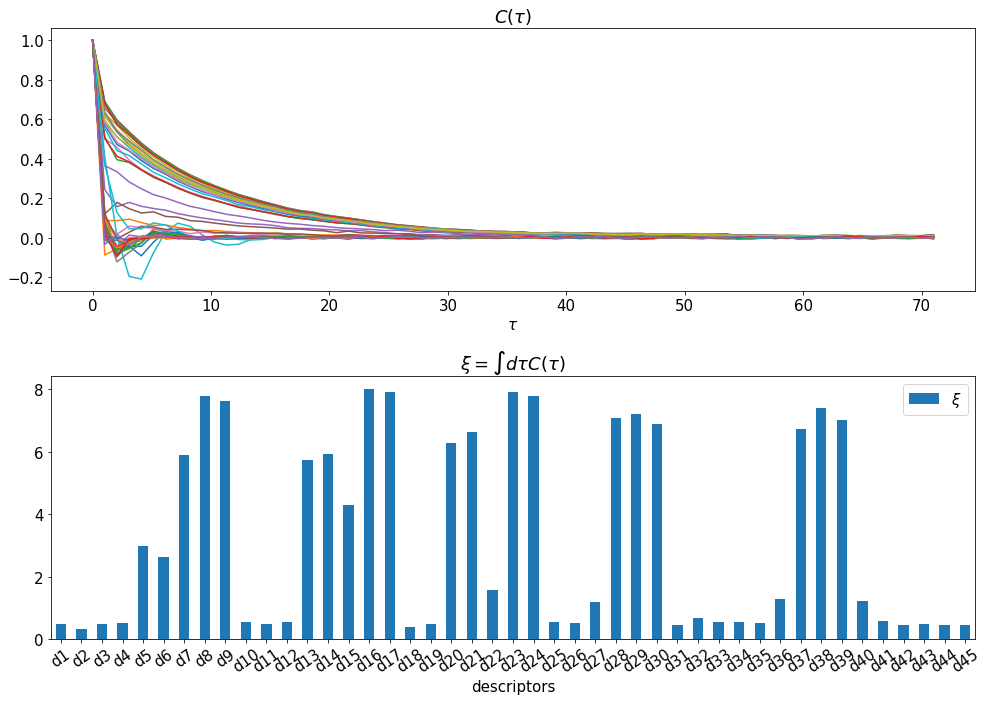

8.008649032771963
0.33276343588561735


In [3]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
fig,axs = plt.subplots(2,1,figsize=(14,10))#,sharey=True)

#-- in ps --#
last=70
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
timescale = np.empty(len(descriptors_names))
k=0
for desc in descriptors_names:
    #print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = data[desc].autocorr(i)
    axs[0].plot(x,acorr)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])
    k+=1

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

$\max(\xi) \approx 8$, $\min(\xi) \approx 0.3$  

# $\tau = 1$ 

In [4]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':1,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": False,
              }
#--------------------------------------#

## DeepTICA Analysis and Export

In [5]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

no weights
Time-lagged pairs:	 99998
Training data:		 69998
Validation data:	 30000
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -1.225      -1.218      0.689  0.532  
100   -1.271      -1.269      0.695  0.575  
150   -1.288      -1.290      0.701  0.587  
200   -1.313      -1.314      0.709  0.604  
250   -1.345      -1.341      0.716  0.628  
300   -1.368      -1.363      0.733  0.634  
350   -1.397      -1.394      0.761  0.636  
400   -1.408      -1.407      0.771  0.637  
450   -1.413      -1.412      0.774  0.639  
500   -1.416      -1.415      0.776  0.640  
550   -1.419      -1.417      0.777  0.641  
600   -1.420      -1.418      0.778  0.642  
650   -1.423      -1.419      0.779  0.644  
INFO: Early stopping
688   -1.423      -1.419      0.780  0.644  
timescales:  [4.016343  2.2702541]
eigenvalues:  [0.77959347 0.6437278 ]


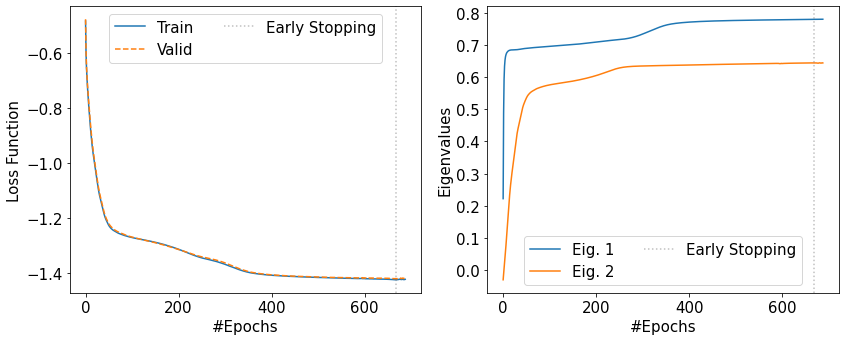

In [6]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [7]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

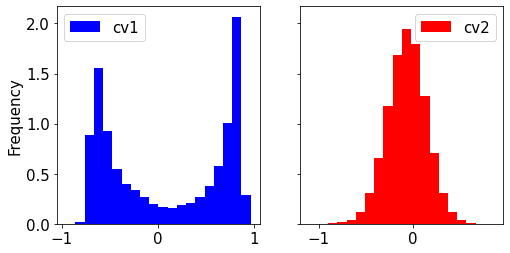

In [8]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

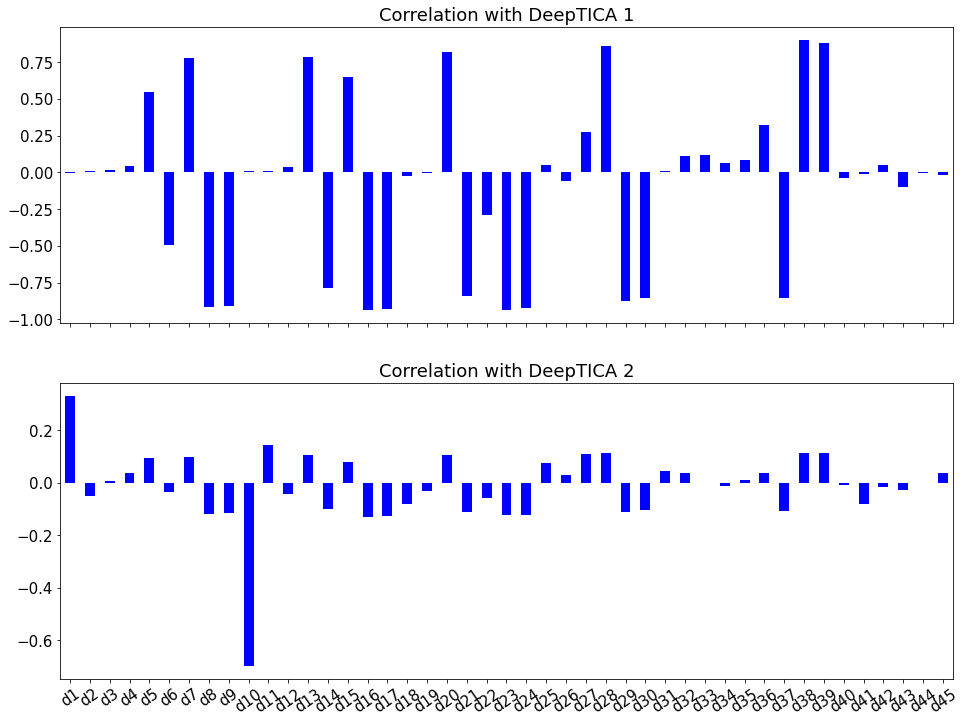

In [9]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

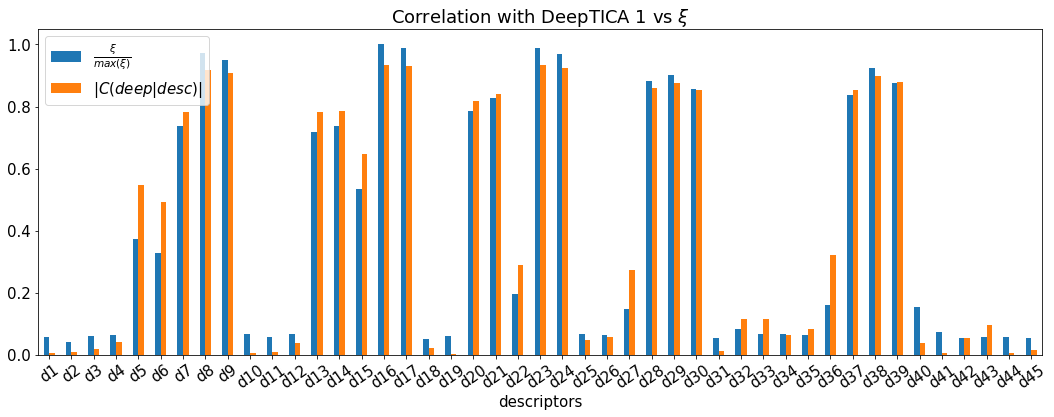

In [10]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
times["timescale"] = times["timescale"]/np.max(times["timescale"])
cols = ["cv1"]
cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
corr = data[cols].corr(method='pearson')
times["corr"] = np.abs(corr["cv1"].to_numpy()[1:])
times.plot(kind="bar",x="descriptors",rot=35,ax=ax,fontsize=15,stacked=False)
ax.set_title(r'Correlation with DeepTICA 1 vs $\xi$')
ax.legend([r"$\frac{\xi}{max(\xi)}$",r"$|C(deep|desc)|$"])
plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

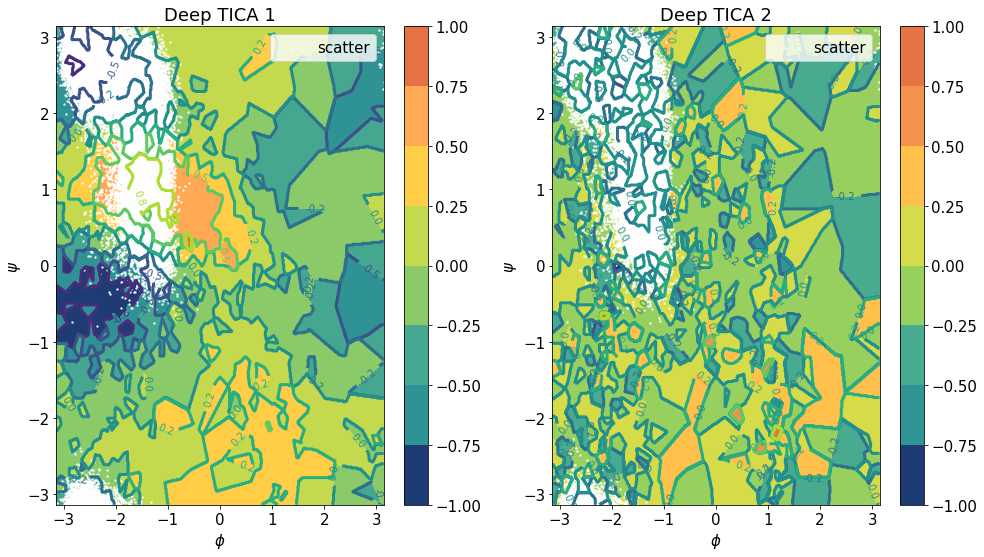

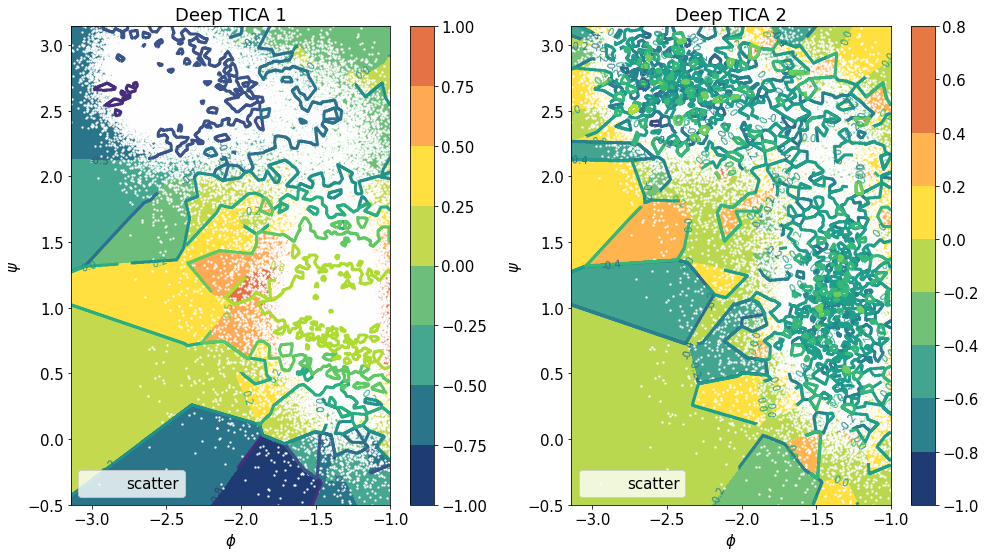

In [11]:
plot_cvs_isolines(model,limits=((-np.pi,np.pi),(-np.pi,np.pi)),interval=50,path="angles/COLVAR",scatter=data)
lim = ((-np.pi,-1),(-0.5,np.pi))
plot_cvs_isolines(model,limits=lim,interval=50,path=folder+"/COLVAR",scatter=data)

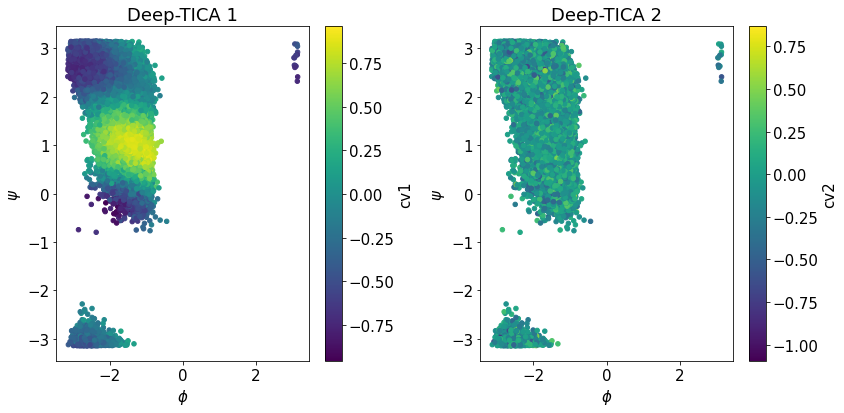

In [12]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [13]:
Boltzmann_product(model,model,X,j=0,k=1)

0.009368842233830315

# $\tau = 10$

## DeepTICA Analysis and Export

In [14]:
train_parameters["lag_time"] = 10
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

no weights
Time-lagged pairs:	 99989
Training data:		 69992
Validation data:	 29997
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.286      -0.275      0.268  0.018  
100   -0.291      -0.276      0.269  0.023  
150   -0.316      -0.295      0.271  0.041  
200   -0.336      -0.298      0.276  0.058  
INFO: Early stopping
207   -0.339      -0.299      0.276  0.060  
timescales:  [7.762498  3.5554705]
eigenvalues:  [0.27575424 0.06005061]


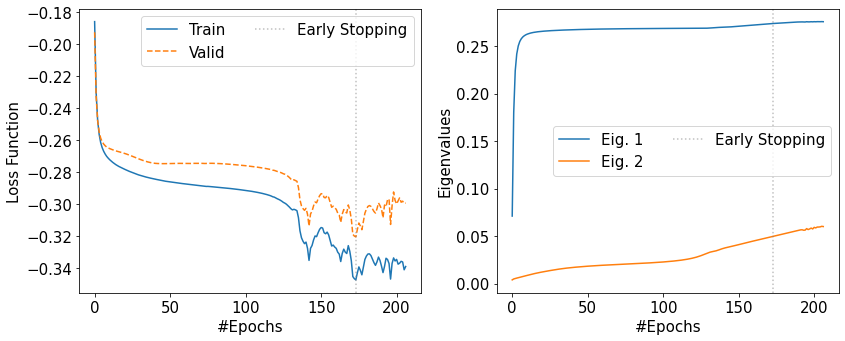

In [15]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [16]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

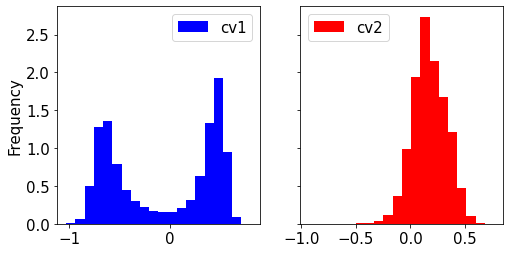

In [17]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

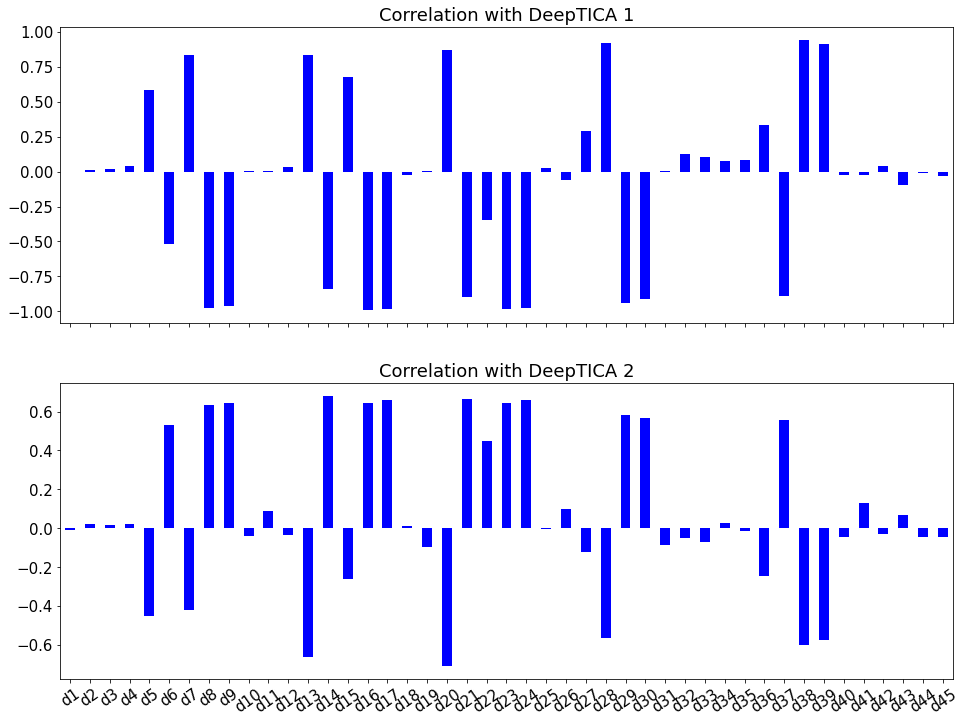

In [18]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

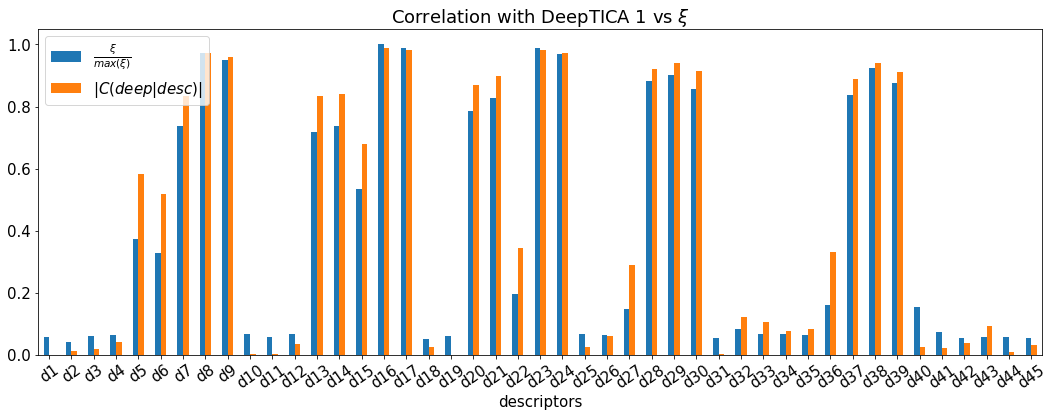

In [19]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
times["timescale"] = times["timescale"]/np.max(times["timescale"])
cols = ["cv1"]
cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
corr = data[cols].corr(method='pearson')
times["corr"] = np.abs(corr["cv1"].to_numpy()[1:])
times.plot(kind="bar",x="descriptors",rot=35,ax=ax,fontsize=15,stacked=False)
ax.set_title(r'Correlation with DeepTICA 1 vs $\xi$')
ax.legend([r"$\frac{\xi}{max(\xi)}$",r"$|C(deep|desc)|$"])
plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

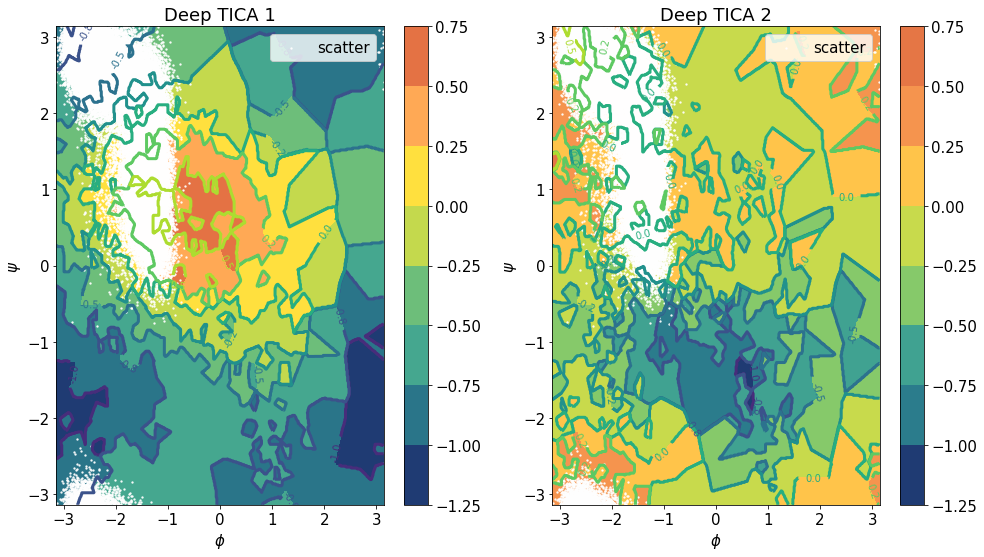

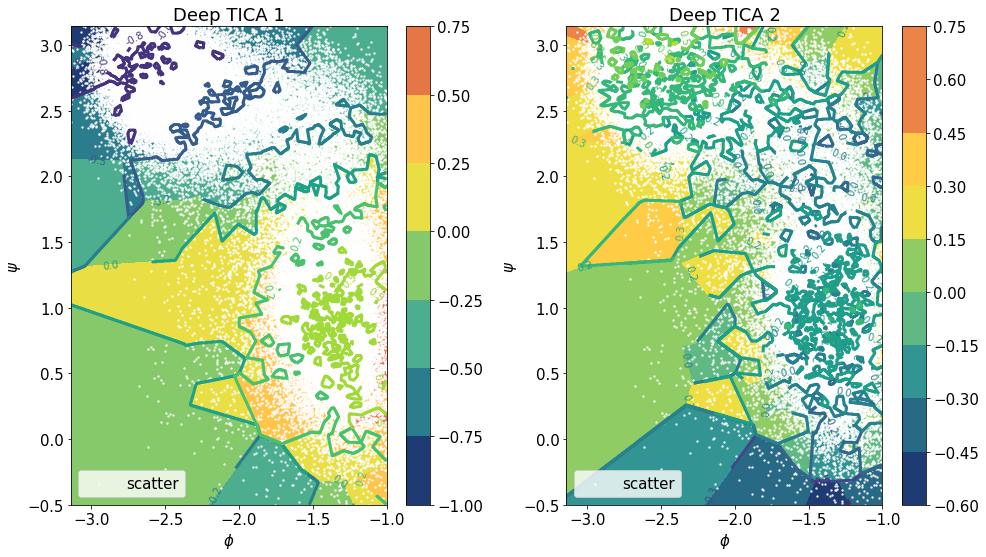

In [20]:
plot_cvs_isolines(model,limits=((-np.pi,np.pi),(-np.pi,np.pi)),interval=50,path="angles/COLVAR",scatter=data)
lim = ((-np.pi,-1),(-0.5,np.pi))
plot_cvs_isolines(model,limits=lim,interval=50,path=folder+"/COLVAR",scatter=data)

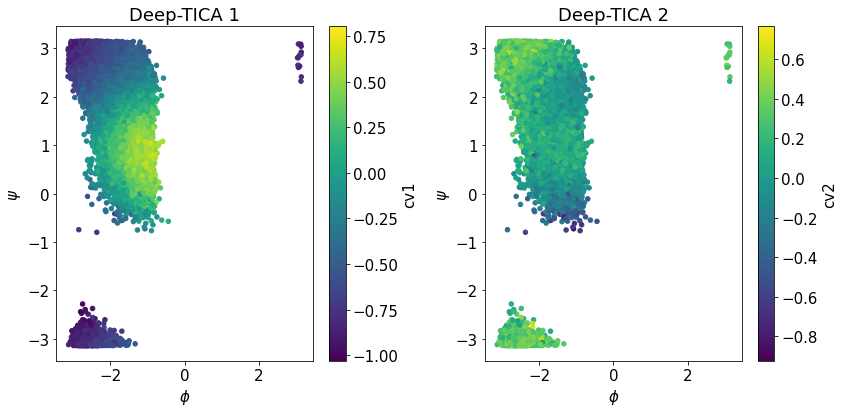

In [21]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [22]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.0569917847063247

# $\tau = 100$

## DeepTICA Analysis and Export

In [23]:
train_parameters["lag_time"] = 100
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

no weights
Time-lagged pairs:	 99899
Training data:		 69929
Validation data:	 29970
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.040      -0.000      0.023  0.014  
100   -0.051      0.001       0.029  0.021  
INFO: Early stopping
120   -0.058      0.000       0.034  0.023  
timescales:  [29.558872 26.649868]
eigenvalues:  [0.03394278 0.02346222]


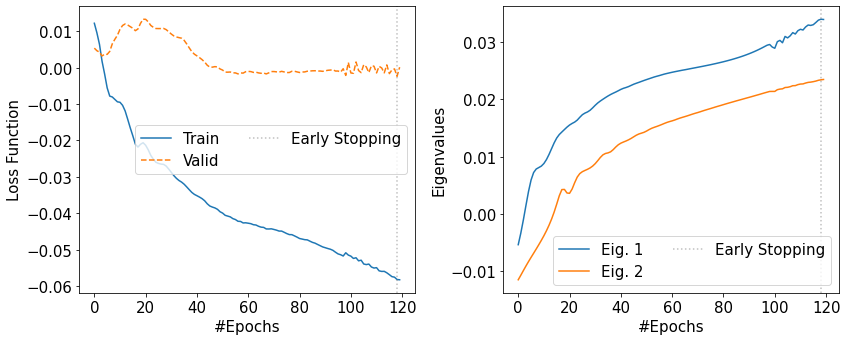

In [24]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [25]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

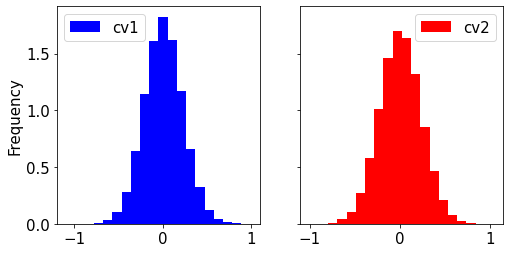

In [26]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

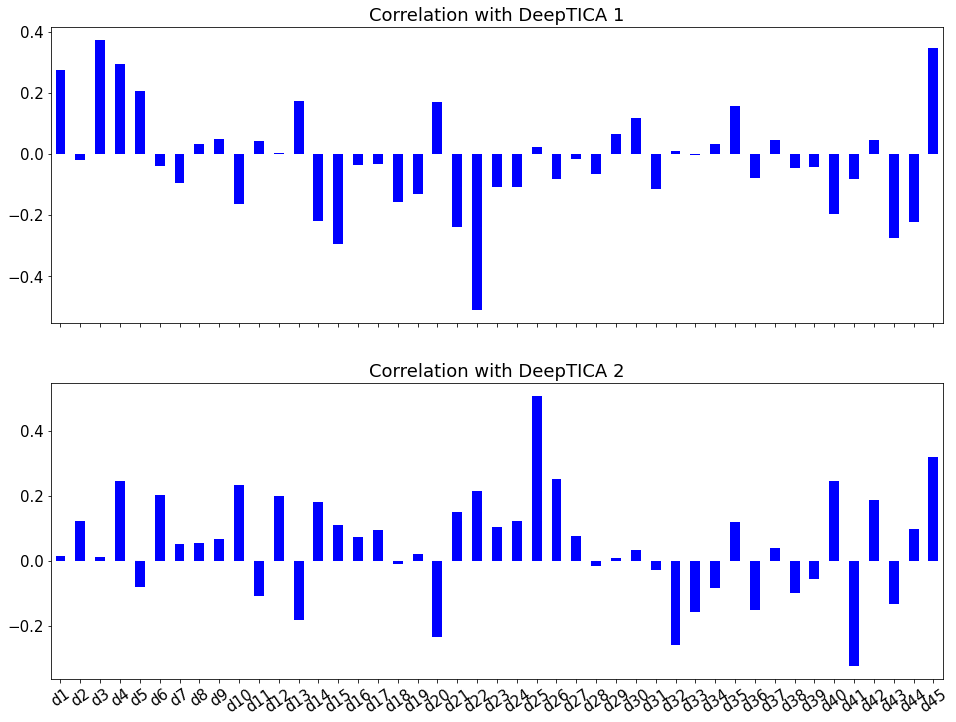

In [27]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

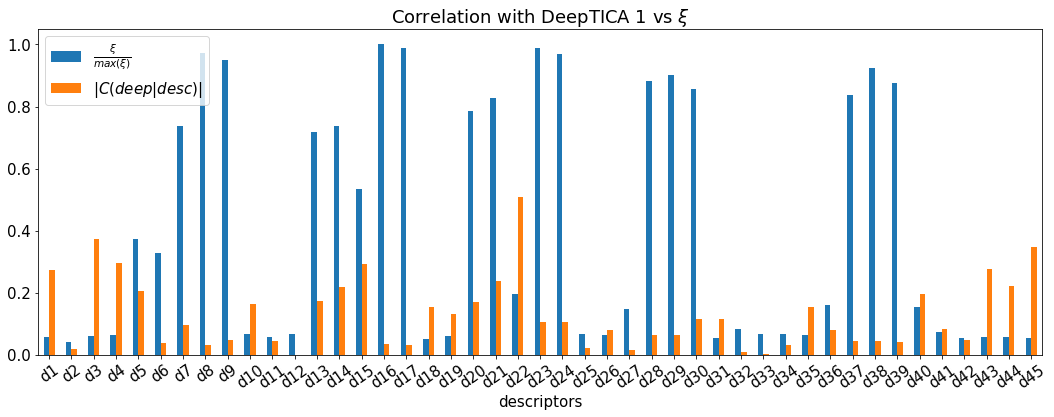

In [28]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
times["timescale"] = times["timescale"]/np.max(times["timescale"])
cols = ["cv1"]
cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
corr = data[cols].corr(method='pearson')
times["corr"] = np.abs(corr["cv1"].to_numpy()[1:])
times.plot(kind="bar",x="descriptors",rot=35,ax=ax,fontsize=15,stacked=False)
ax.set_title(r'Correlation with DeepTICA 1 vs $\xi$')
ax.legend([r"$\frac{\xi}{max(\xi)}$",r"$|C(deep|desc)|$"])
plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

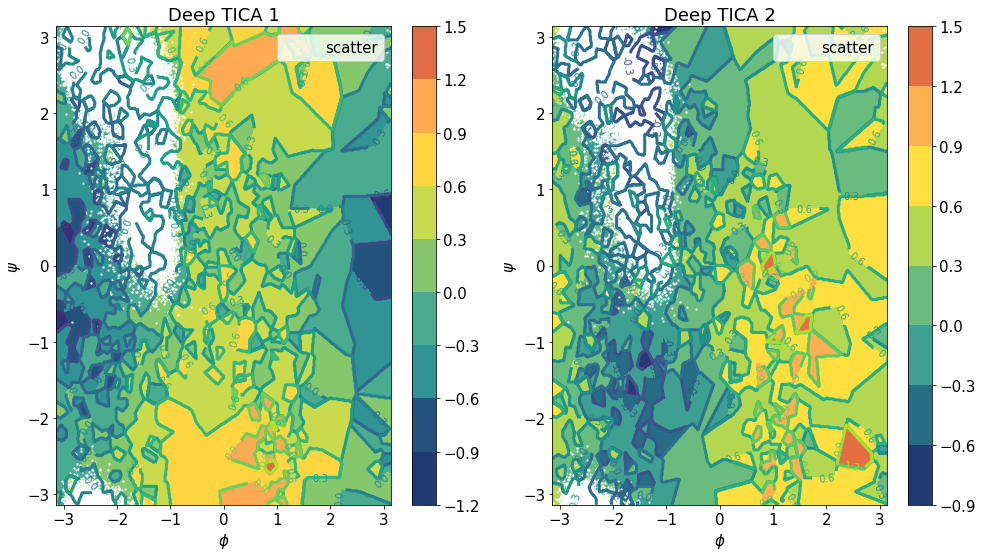

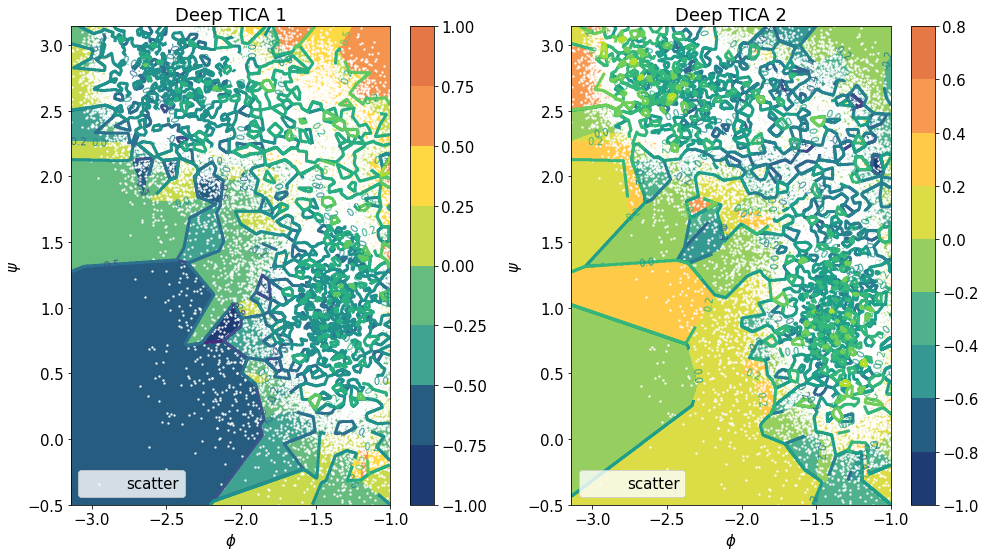

In [29]:
plot_cvs_isolines(model,limits=((-np.pi,np.pi),(-np.pi,np.pi)),interval=50,path="angles/COLVAR",scatter=data)
lim = ((-np.pi,-1),(-0.5,np.pi))
plot_cvs_isolines(model,limits=lim,interval=50,path=folder+"/COLVAR",scatter=data)

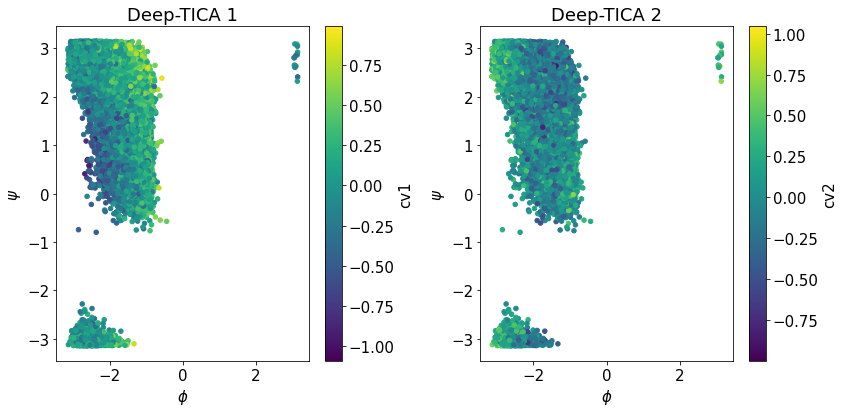

In [30]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [31]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.0003694690200073995

# $\tau = 500$

## DeepTICA Analysis and Export

In [32]:
train_parameters["lag_time"] = 500
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

no weights
Time-lagged pairs:	 99499
Training data:		 69649
Validation data:	 29850
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.050      -0.010      0.024  0.022  
100   -0.053      -0.006      0.028  0.024  
INFO: Early stopping
113   -0.056      -0.007      0.030  0.025  
timescales:  [142.15791 135.31871]
eigenvalues:  [0.02968198 0.02484793]


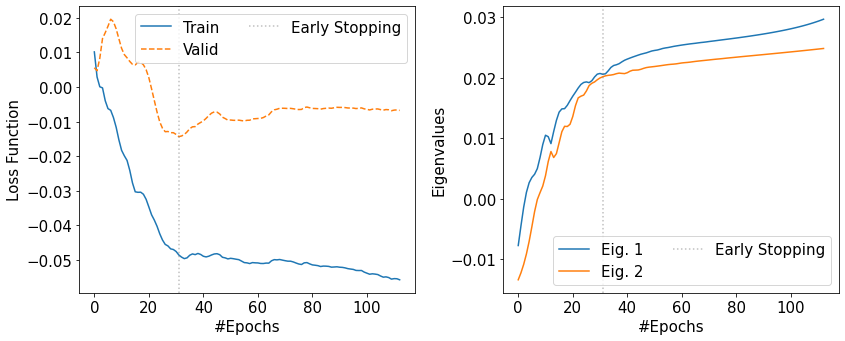

In [33]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [34]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

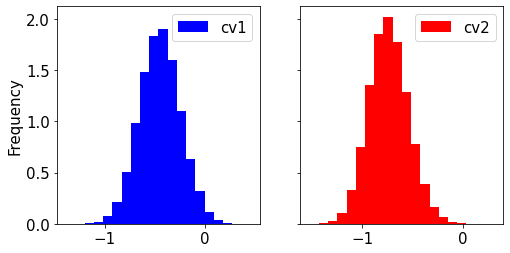

In [35]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

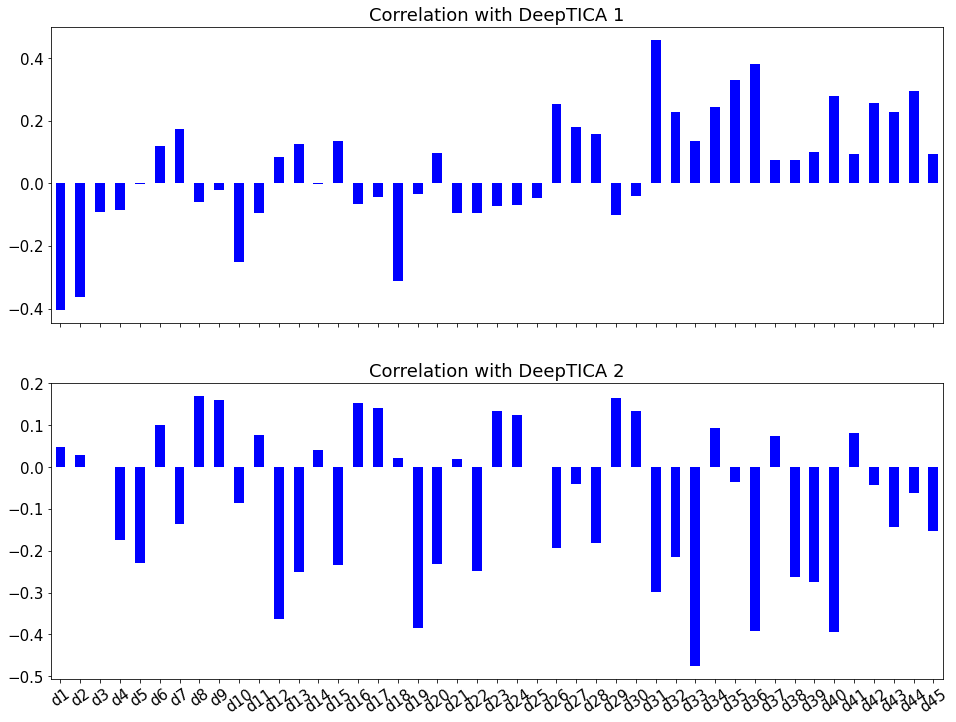

In [36]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

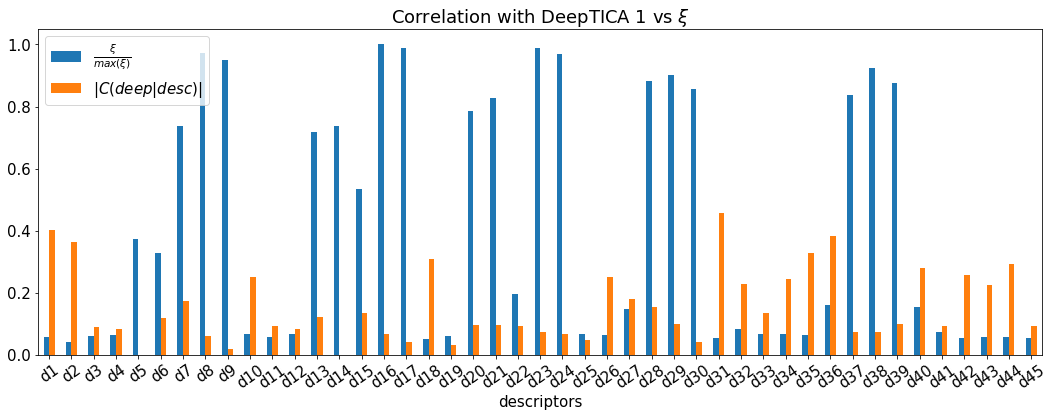

In [37]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
times["timescale"] = times["timescale"]/np.max(times["timescale"])
cols = ["cv1"]
cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
corr = data[cols].corr(method='pearson')
times["corr"] = np.abs(corr["cv1"].to_numpy()[1:])
times.plot(kind="bar",x="descriptors",rot=35,ax=ax,fontsize=15,stacked=False)
ax.set_title(r'Correlation with DeepTICA 1 vs $\xi$')
ax.legend([r"$\frac{\xi}{max(\xi)}$",r"$|C(deep|desc)|$"])
plt.show()

### Isolines  
We can use the data obtained from **angles** folder, biasing both $\psi$ and $\phi$ angles, to plot the isolines of the new Cvs   

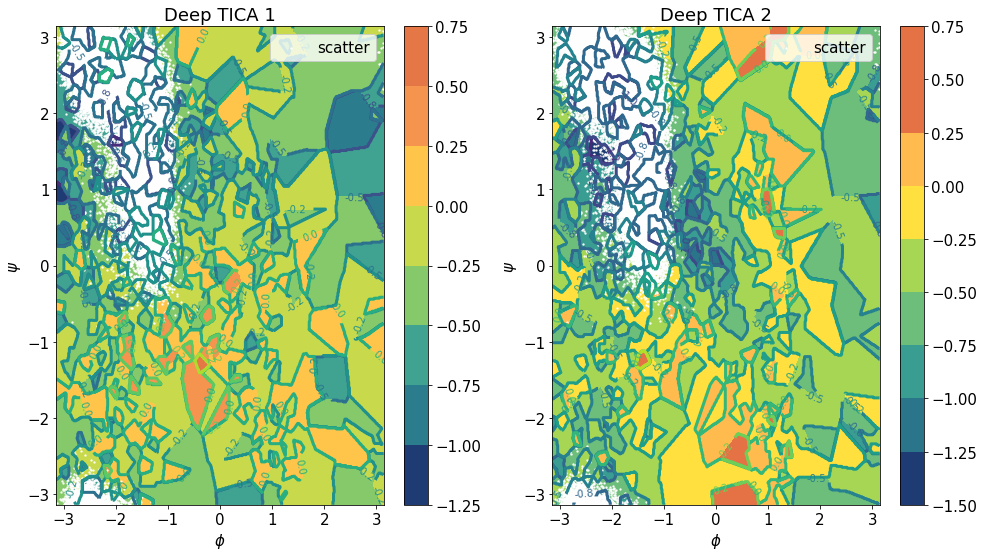

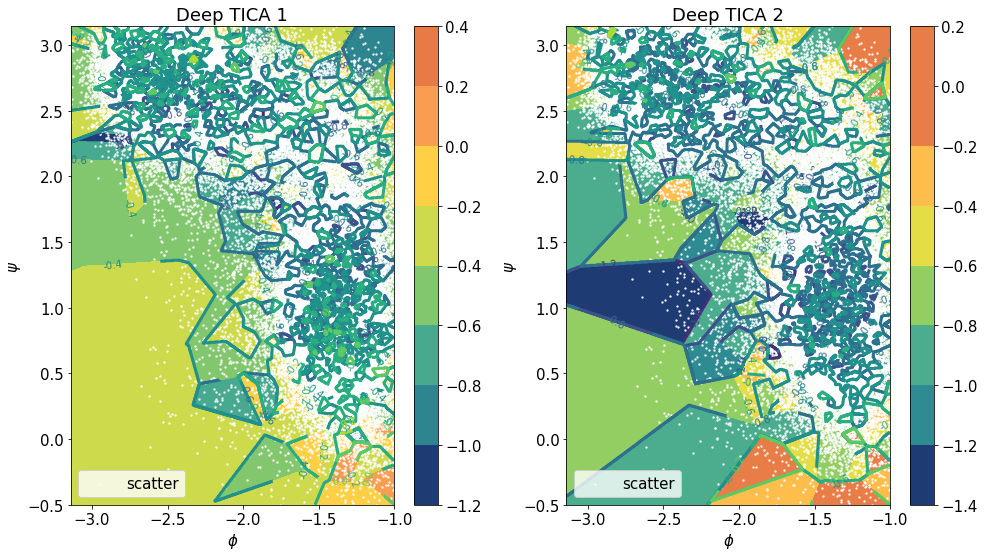

In [38]:
plot_cvs_isolines(model,limits=((-np.pi,np.pi),(-np.pi,np.pi)),interval=50,path="angles/COLVAR",scatter=data)
lim = ((-np.pi,-1),(-0.5,np.pi))
plot_cvs_isolines(model,limits=lim,interval=50,path=folder+"/COLVAR",scatter=data)

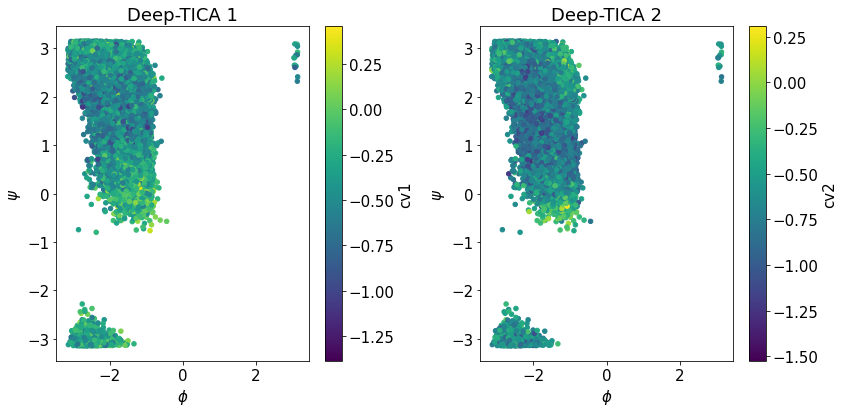

In [39]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [40]:
Boltzmann_product(model,model,X,j=0,k=1)

0.3211905023040464